# Problem Set 1

#### Exercise 1

(a) Download quarterly real GDP data for a country of your choice and import this
into Matlab.

In [29]:
# we will use gdp data for the US downloaded from FRED as .xls file
import pandas as pd
import datetime as dt

df = pd.read_excel('GDPC1.xls')
df = df[10:]
df.columns = 'Date', 'real_GDP'
df['Date'] = pd.to_datetime(df['Date'])

# define real_GDP as type float
df['real_GDP'] = df.real_GDP.astype(float)
df = df.set_index('Date')
df.head()

,real_GDP
Date,
1947-01-01,2033.061
1947-04-01,2027.639
1947-07-01,2023.452
1947-10-01,2055.103
1948-01-01,2086.017


(b) Plot the natural log of the real GDP data versus time.

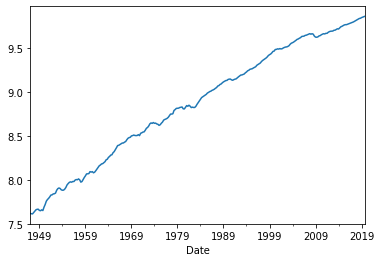

In [30]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# add log_GDP col
df['log_GDP'] = np.log(df.real_GDP)
df

# plot
ax = df['log_GDP'].plot(kind = 'line')
plt.show()

(c) Estimate the linear trend and add this to your plot. (Hint: You will need to
estimate the time trend and may find it helpful to refer back to the exercise on
OLS regression in Matlab from Lecture 2.) Do you notice any obvious trend
breaks?

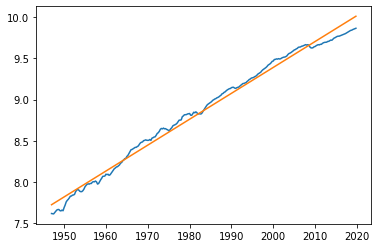

In [31]:
# here we use the linregress function from scipy.stats
from scipy.stats import linregress

# define x = time
df['time'] = np.linspace(1, len(df), len(df))
lm_fit = linregress(x = df['time'], y = df['log_GDP'])
slope, intercept = lm_fit[0:2]
df['fitted'] = slope * df.time + intercept

# plot
fig, ax = plt.subplots()
ax.plot(df['log_GDP'])
ax.plot(df['fitted'])
plt.show()

(d) Compute the deviations of log real GDP from the linear trend and plot them
versus time. Since you are using logs, the deviations of the actual log real GDP
from trend roughly equals percentage deviations. Comment on your results with
respect to the magnitude of trend deviations and how persistent these deviations
tend to be. How many business cycles do you observe in your data when defining
the growth trend in this way?

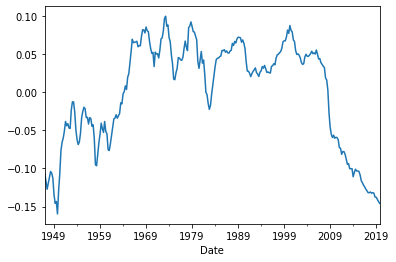

In [32]:
df['residuals'] = df.log_GDP - df.fitted
df.residuals.plot(kind = 'line')
plt.show()

(e) Compute and plot the growth rate of real GDP with respect to time. (Hint: You
have already computed the log of real GDP, so computing the first difference of
this series will give you the growth rate.) Compute the average growth rate of
real GDP and add this to your plot. How does this figure differ from your figure
in part d?

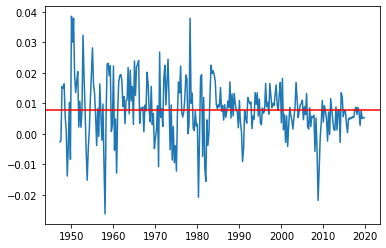

In [33]:
df['growth_rate'] = df.log_GDP.diff()
average_growth_rate = np.mean(df.growth_rate)

fig, ax = plt.subplots()
ax.plot(df.growth_rate)
ax.axhline(y = average_growth_rate, c = 'r')
plt.show()

(f) Write a program in Matlab to apply the Hodrick-Prescott filter described in Lecture 3 to decompose the real GDP data into trend and cyclical components. Plot
the HP filtered trend component versus time. Include the log real GDP data in
your plot as well. Comment. (Note: You can use the built in HP filter function
to check your work, but you should write your own script or function to solve the
problem that characterizes the HP filter discussed in Lecture Notes 3.)

In [34]:
# we will write a new class to solve this problem
class Prescott_Filter:
    """
    Implements the HP-Filter for decomposing time-series data.
    Provide a time-series object (array) and a desired smoothing value for lambda.
    """
    def __init__(self, s, λ = 1600):
        self.s, self.λ = s, λ
        
    def C(self):
        "C-matrix (TxT) according to minimization problem"
        T = len(self.s)
        C = np.zeros(shape = (T, T))
        C[0, 0:3] = [1, -2, 1]
        C[1, 0:4] = [-2, 5, -4, 1]
        C[2, 0:5] = [1, -4, 6, -4, 1]
        C[3, 0:6] = [0, 1, -4, 6, -4, 1]
        C[-3, -5:] = [1, -4, 6, -4, 1]
        C[-2, -4:] = [1, -4, 5, -2]
        C[-1, -3:] = [1, -2, 1]
        return C
    
    def trend(self):
        "compute trend component"
        A = self.λ * self.C() + np.identity(len(self.s)) # brackets are kind of important
        b = np.log(self.s)
        trend = np.linalg.solve(a = A, b = b)
        return trend
        
    def cyclical(self):
        "compute cyclical component"
        cyclical = self.s - self.trend() # brackets are kind of important
        return cyclical

In [35]:
hp = Prescott_Filter(s = pd.Series(df['real_GDP']))
df['trend'] = hp.trend()
df['cyclical'] = hp.cyclical()

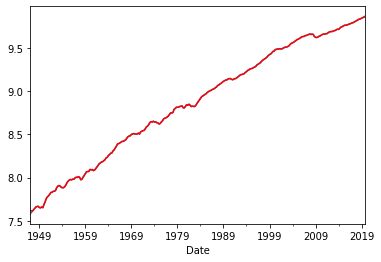

In [36]:
# plot
fig, ax = plt.subplots()
ax = df.trend.plot()
ax = df.log_GDP.plot(c = 'r')
plt.show()

(g) Plot the cyclical component of real GDP versus time. Comment on your results
with respect to the magnitude of trend deviations as well as their persistence. How
many business cycles do you observe in your data? Comment on your results, do
you see any notable features in the data across time or in comparison to the
measures you constructed in parts d and e?

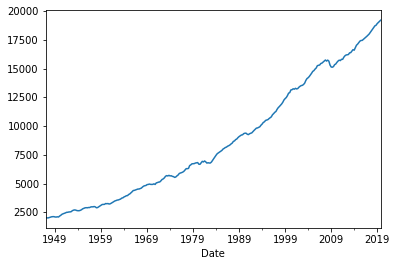

In [37]:
ax = df.cyclical.plot()
plt.show()

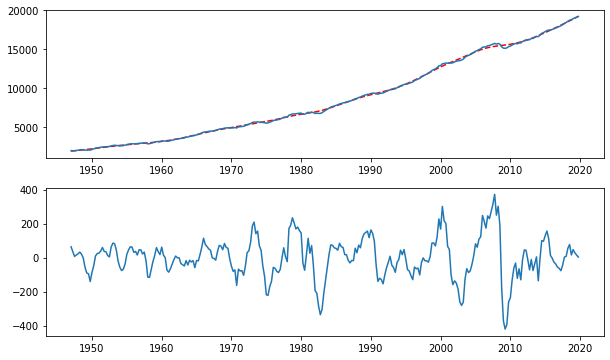

In [38]:
# compare to implemented method
import statsmodels.api as sm

cycle, trend = sm.tsa.filters.hpfilter(df.real_GDP, 1600)
df['cycle_method'] = cycle
df['trend_method'] = trend

# plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
ax1.plot(df.trend_method, 'r--')
ax1.plot(df.real_GDP)
ax2.plot(df.cycle_method)
plt.show()

(h) Compute summary statistics (mean, standard deviation, autocorrelations, maximum, mimimum, percent of observations that are greater than zero) for the
growth rate and HP filtered cyclical component of real GDP. Use these summary
statistics to construct some business cycle facts of the following style:
- Real GDP has a volatility of XXX % around trend or XXX % when
considering HP-filtered series.
- The cyclical component of real GDP is/isn´t highly persistent. (Hint: Are positive deviations followed with high liklihood with positive deviations? Look
at the autocorrelations.)
- Recessions are short and sharp, but expansions are long and gradual. (Hint:
Do you notice that positive deviations are more/less likely than negative
deviations from trend.)
- How common is it that the growth rate of real GDP actually becomes negative?

#### Exercise 2
Simulate and plot the a time series for capital intensity in the Solow model for the exact
model and a log-linearized version of the model (generated with the same sequence
of residuals) just as in Figure 1.3 of McCandless. Compare and discuss how the
exact simulation differs from the log-linearized approximation. How sensitive are your
conclusions to the magnitude of the technology shock?

In [39]:
# test for symbolic manipulation: rearrange for steady state... (but I think this yields a complexe solution...)
# in the class below, I find st-st k by rootfinding
from sympy import symbols, pprint, solve
k, n, σ, A, θ, δ = symbols('k n σ A θ δ', real = True)
solve(k - (1 / n) * (σ * A * k**θ + (1 - δ) * k), k)

[(A*σ/(n + δ - 1))**(-1/(θ - 1))]

In [62]:
from scipy.optimize import newton

# We define a class 'Solow' and compute the exact dynamics in one method and the log-lin version in another method.
# We are ultimately interested in the dynamics of capital (as all the other variables evolve around the accumulation of capital).
# We choose the initial parameters as in McCandless.
class Solow:
    """
    Implements the Solow growth model with either the exact update rule according to:
    
    k_{t+1} = ((1 - δ)k_t + σ A(e^(ϵ_t)) (k_t)^θ / (1 + n)
    
    or a log-linearized update rule according to:
    
    k_{t+1} = B k_t + C ϵ_t, where B = ((δ + n)θ + 1 - δ) / (1 + n) and C = (δ + n) / (1 + n)
    
    """
    def __init__(self,
                 δ = 0.1,
                 k_general = 1,
                 k_log_lin = 1,
                 σ = 0.2,
                 A = 1,
                 θ = 0.36,
                 n = 0.02,
                 ϵ = 0):
        self.δ, self.k_general, self.k_log_lin, self.σ, self.A, self.θ, self.n, self.ϵ = δ, k_general, k_log_lin, σ, A, θ, n, ϵ
    
    def st_st(self):
        "Steady state capital stock"
        f = lambda k: (1 + self.n) * k - self.σ * self.A * k**self.θ + self.δ * k - k
        return newton(f, x0 = 1)
    
    def h_general(self):
        "Implement RHS of general formula"
        # recall the power operator is ** instead of ^
        return ((1 - self.δ) * self.k_general + self.σ * self.A * (np.exp(self.ϵ)) * (self.k_general)**self.θ) / (1 + self.n)
        
    def h_log_lin(self):
        "Implement RHS of log-lin formula"
        B = ((self.δ + self.n) * self.θ + 1 - self.δ) / (1 + self.n)
        C = (self.δ + self.n) / (1 + self.n)
        return B * self.k_log_lin + C * self.ϵ
    
    def update_general(self):
        self.k_general = self.h_general()
        
    def update_log_lin(self):
        self.k_log_lin = self.h_log_lin()
        
    def update_shock(self):
        self.ϵ = np.random.normal(0, 0.2)
        
    def generate_sequence_general(self, t):
        "Generate time-series sequence according to diff equation"
        path = []
        for t in range(t):
            path.append(self.k_general)
            self.update_shock() # new shock
            self.update_general()
        return path
            
    def generate_sequence_log_lin(self, t):
        "Generate time-series sequence according to diff equation"
        path = []
        for t in range(t):
            path.append(self.k_log_lin)
            self.update_shock()
            self.update_log_lin()
        return path
    
    def general_vs_log_lin(self, t):
        "Compare approximation to general solution with same shocks"
        path_general = []
        path_log_lin = []
        for t in range(t):
            path_general.append(self.k_general)
            path_log_lin.append(self.k_log_lin)
            self.update_shock()
            self.update_general()
            self.update_log_lin()
        # transform path_log_lin
        path_log_lin = self.st_st() + np.array(path_log_lin) * self.st_st() # be aware of what happens when you multiply [] * 3!
        return path_general, path_log_lin

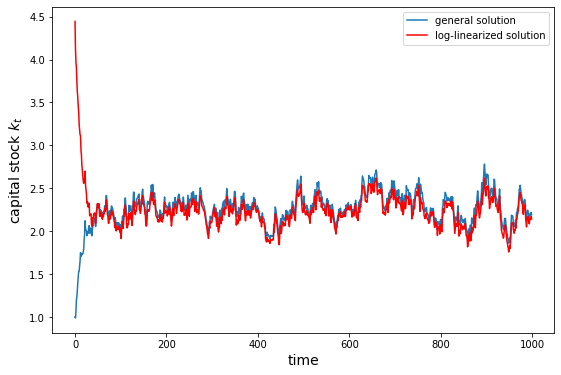

In [71]:
s = Solow()
s_compare = s.general_vs_log_lin(t = 1000)
s_general = s_compare[0]
s_log_lin = s_compare[1]

fig, ax = plt.subplots(figsize = (9, 6))
ax.plot(s_general, label = 'general solution')
ax.plot(s_log_lin, 'r', label = 'log-linearized solution')
ax.set_xlabel('time', fontsize = 14)
ax.set_ylabel('capital stock $k_t$', fontsize = 14)
ax.legend()
plt.show()